In [1]:
"""
==================================================
SAFETY EQUIPMENT DETECTOR - DATASET CREATION
==================================================
Project: Safety Equipment Detection (Construction Sites)
Purpose: Create and validate custom YOLO dataset
Dataset Version: v3 (Production)
Date: October 26-27, 2025

DATASET STATS:
──────────────
Source Images: 104 (from Roboflow)
Total Images (with augmentation): 246
├─ Train: 213 images
├─ Valid: 22 images
└─ Test: 11 images

Classes: 5
├─ person
├─ helmet
├─ vest
├─ no-helmet
└─ no-vest

==================================================
"""
print("=" * 60)
print("DATASET CREATION - SAFETY EQUIPMENT DETECTOR")
print("=" * 60)
print("\n📦 Creating production-ready dataset!\n")

DATASET CREATION - SAFETY EQUIPMENT DETECTOR

📦 Creating production-ready dataset!



In [2]:
# ============================================================
# IMPORTS & SETUP
# ============================================================
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import os
import shutil
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ All imports successful!")
print("=" * 60)

✅ All imports successful!


In [3]:
# ============================================================
# DATASET CONFIGURATION
# ============================================================
print("\n" + "="*60)
print("DATASET CONFIGURATION")
print("="*60)

# Dataset path (UPDATE THIS TO YOUR PATH!)
dataset_root = Path(r'C:\Users\audrey\Documents\ML_Journey\datasets\Safety-Equipment-Detector.v3-v3.yolov8')
yaml_path = dataset_root / 'data.yaml'

print(f"\n📂 Dataset Location:")
print(f"   Root: {dataset_root}")
print(f"   Config: {yaml_path}")

# Verify dataset exists
if dataset_root.exists():
    print("\n✅ Dataset directory found!")
else:
    print("\n❌ Dataset directory not found!")
    print(f"   Expected: {dataset_root}")
    print("   Please update the path above!")


DATASET CONFIGURATION

📂 Dataset Location:
   Root: C:\Users\audrey\Documents\ML_Journey\datasets\Safety-Equipment-Detector.v3-v3.yolov8
   Config: C:\Users\audrey\Documents\ML_Journey\datasets\Safety-Equipment-Detector.v3-v3.yolov8\data.yaml

✅ Dataset directory found!


In [4]:
# ============================================================
# LOAD DATASET CONFIGURATION
# ============================================================
print("\n" + "="*60)
print("LOADING DATASET CONFIGURATION")
print("="*60)

# Load data.yaml
print(f"\n📥 Loading dataset configuration...")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("\n📋 Dataset Configuration:")
print(f"   Path: {data_config.get('path', 'Not specified')}")
print(f"   Classes: {data_config['names']}")
print(f"   Number of classes: {data_config['nc']}")

# Handle both list and dict formats for class names
class_names_raw = data_config['names']
if isinstance(class_names_raw, list):
    # Convert list to dict {0: 'class1', 1: 'class2', ...}
    class_names = {i: name for i, name in enumerate(class_names_raw)}
else:
    class_names = class_names_raw

print("\n🏷️  Class Mapping:")
for class_id, class_name in class_names.items():
    print(f"   {class_id}: {class_name}")

print("\n✅ Configuration loaded successfully!")


LOADING DATASET CONFIGURATION

📥 Loading dataset configuration...

📋 Dataset Configuration:
   Path: Not specified
   Classes: ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']
   Number of classes: 5

🏷️  Class Mapping:
   0: helmet
   1: no-helmet
   2: no-vest
   3: person
   4: vest

✅ Configuration loaded successfully!


In [5]:
# ============================================================
# VERIFY FOLDER STRUCTURE
# ============================================================
print("\n" + "="*60)
print("FOLDER STRUCTURE VERIFICATION")
print("="*60)

splits = ['train', 'valid', 'test']
structure_ok = True

for split in splits:
    images_dir = dataset_root / split / 'images'
    labels_dir = dataset_root / split / 'labels'
    
    if images_dir.exists() and labels_dir.exists():
        img_count = len(list(images_dir.glob('*')))
        lbl_count = len(list(labels_dir.glob('*.txt')))
        
        print(f"\n✅ {split.upper()}:")
        print(f"   Images: {img_count}")
        print(f"   Labels: {lbl_count}")
        
        if img_count != lbl_count:
            print(f"   ⚠️  WARNING: Image and label count mismatch!")
            structure_ok = False
    else:
        print(f"\n❌ {split.upper()}: Missing folders!")
        structure_ok = False

if structure_ok:
    print("\n" + "="*60)
    print("✅ DATASET STRUCTURE IS VALID!")
    print("="*60)
else:
    print("\n" + "="*60)
    print("⚠️  DATASET HAS STRUCTURAL ISSUES!")
    print("="*60)

# Calculate total
train_imgs = len(list((dataset_root / 'train' / 'images').glob('*')))
valid_imgs = len(list((dataset_root / 'valid' / 'images').glob('*')))
test_imgs = len(list((dataset_root / 'test' / 'images').glob('*')))
total_imgs = train_imgs + valid_imgs + test_imgs

print(f"\n📊 DATASET SUMMARY:")
print(f"   Train: {train_imgs} images ({train_imgs/total_imgs*100:.1f}%)")
print(f"   Valid: {valid_imgs} images ({valid_imgs/total_imgs*100:.1f}%)")
print(f"   Test:  {test_imgs} images ({test_imgs/total_imgs*100:.1f}%)")
print(f"   ────────────────────")
print(f"   Total: {total_imgs} images")


FOLDER STRUCTURE VERIFICATION

✅ TRAIN:
   Images: 213
   Labels: 213

❌ VALID: Missing folders!

✅ TEST:
   Images: 11
   Labels: 11

⚠️  DATASET HAS STRUCTURAL ISSUES!

📊 DATASET SUMMARY:
   Train: 213 images (90.3%)
   Valid: 12 images (5.1%)
   Test:  11 images (4.7%)
   ────────────────────
   Total: 236 images


In [6]:
# ============================================================
# CLASS DISTRIBUTION ANALYSIS
# ============================================================
print("\n" + "="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

def analyze_labels(labels_dir, class_names):
    """Count instances of each class"""
    class_counts = Counter()
    total_boxes = 0
    
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    total_boxes += 1
    
    return class_counts, total_boxes

# Analyze each split
results = {}
for split in splits:
    labels_dir = dataset_root / split / 'labels'
    if labels_dir.exists():
        class_counts, total = analyze_labels(labels_dir, class_names)
        results[split] = {'counts': class_counts, 'total': total}
        
        print(f"\n{split.upper()} SET:")
        print(f"   Total annotations: {total}")
        print(f"   Class breakdown:")
        for class_id in sorted(class_counts.keys()):
            count = class_counts[class_id]
            percentage = (count / total * 100) if total > 0 else 0
            print(f"      {class_names[class_id]:<12}: {count:4d} ({percentage:5.1f}%)")

print("\n✅ Class distribution analyzed!")


CLASS DISTRIBUTION ANALYSIS

TRAIN SET:
   Total annotations: 2022
   Class breakdown:
      helmet      :  534 ( 26.4%)
      no-helmet   :  150 (  7.4%)
      no-vest     :  351 ( 17.4%)
      person      :  672 ( 33.2%)
      vest        :  315 ( 15.6%)

TEST SET:
   Total annotations: 84
   Class breakdown:
      helmet      :   18 ( 21.4%)
      no-helmet   :   11 ( 13.1%)
      no-vest     :   14 ( 16.7%)
      person      :   28 ( 33.3%)
      vest        :   13 ( 15.5%)

✅ Class distribution analyzed!



CREATING CLASS DISTRIBUTION VISUALIZATIONS

✅ Saved: class_distribution.png


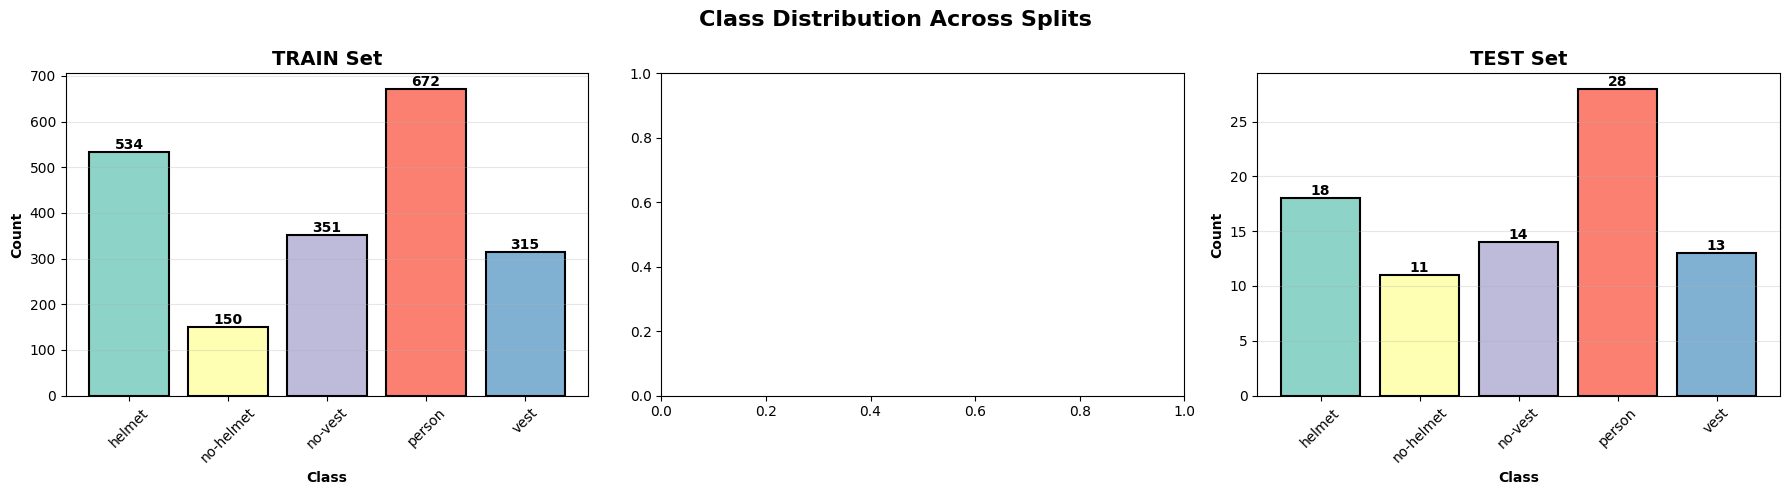

In [7]:
# ============================================================
# VISUALIZE CLASS DISTRIBUTION
# ============================================================
print("\n" + "="*60)
print("CREATING CLASS DISTRIBUTION VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Class Distribution Across Splits', fontsize=16, fontweight='bold')

for idx, split in enumerate(splits):
    if split in results:
        counts = results[split]['counts']
        
        # Prepare data for plotting
        classes = [class_names[i] for i in sorted(counts.keys())]
        values = [counts[i] for i in sorted(counts.keys())]
        colors = plt.cm.Set3(range(len(classes)))
        
        # Create bar chart
        bars = axes[idx].bar(classes, values, color=colors, edgecolor='black', linewidth=1.5)
        axes[idx].set_title(f'{split.upper()} Set', fontweight='bold', fontsize=14)
        axes[idx].set_xlabel('Class', fontweight='bold')
        axes[idx].set_ylabel('Count', fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{int(val)}',
                          ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: class_distribution.png")
plt.show()

In [8]:
# ============================================================
# CLASS IMBALANCE ANALYSIS
# ============================================================
print("\n" + "="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)

if 'train' in results and results['train']['counts']:
    train_counts = results['train']['counts']
    max_count = max(train_counts.values())
    min_count = min(train_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    print(f"\n📊 Imbalance Statistics:")
    print(f"   Most common class: {max_count} instances")
    print(f"   Least common class: {min_count} instances")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 10:
        print("\n⚠️  HIGH IMBALANCE DETECTED!")
        print("   Recommendation: Collect more data for underrepresented classes")
        print("   Or use class weights during training")
    elif imbalance_ratio > 5:
        print("\n⚠️  MODERATE IMBALANCE")
        print("   Recommendation: Consider class weights or balanced sampling")
        print("   Current ratio is acceptable for many applications")
    else:
        print("\n✅ CLASS DISTRIBUTION IS RELATIVELY BALANCED")
        print("   Good for training!")
else:
    print("\n⚠️  No training data found for imbalance analysis")

print("\n✅ Imbalance analysis complete!")


CLASS IMBALANCE ANALYSIS

📊 Imbalance Statistics:
   Most common class: 672 instances
   Least common class: 150 instances
   Imbalance ratio: 4.48:1

✅ CLASS DISTRIBUTION IS RELATIVELY BALANCED
   Good for training!

✅ Imbalance analysis complete!



VISUALIZING SAMPLE ANNOTATIONS

📸 Creating annotation visualizations...

✅ Saved: sample_annotations.png


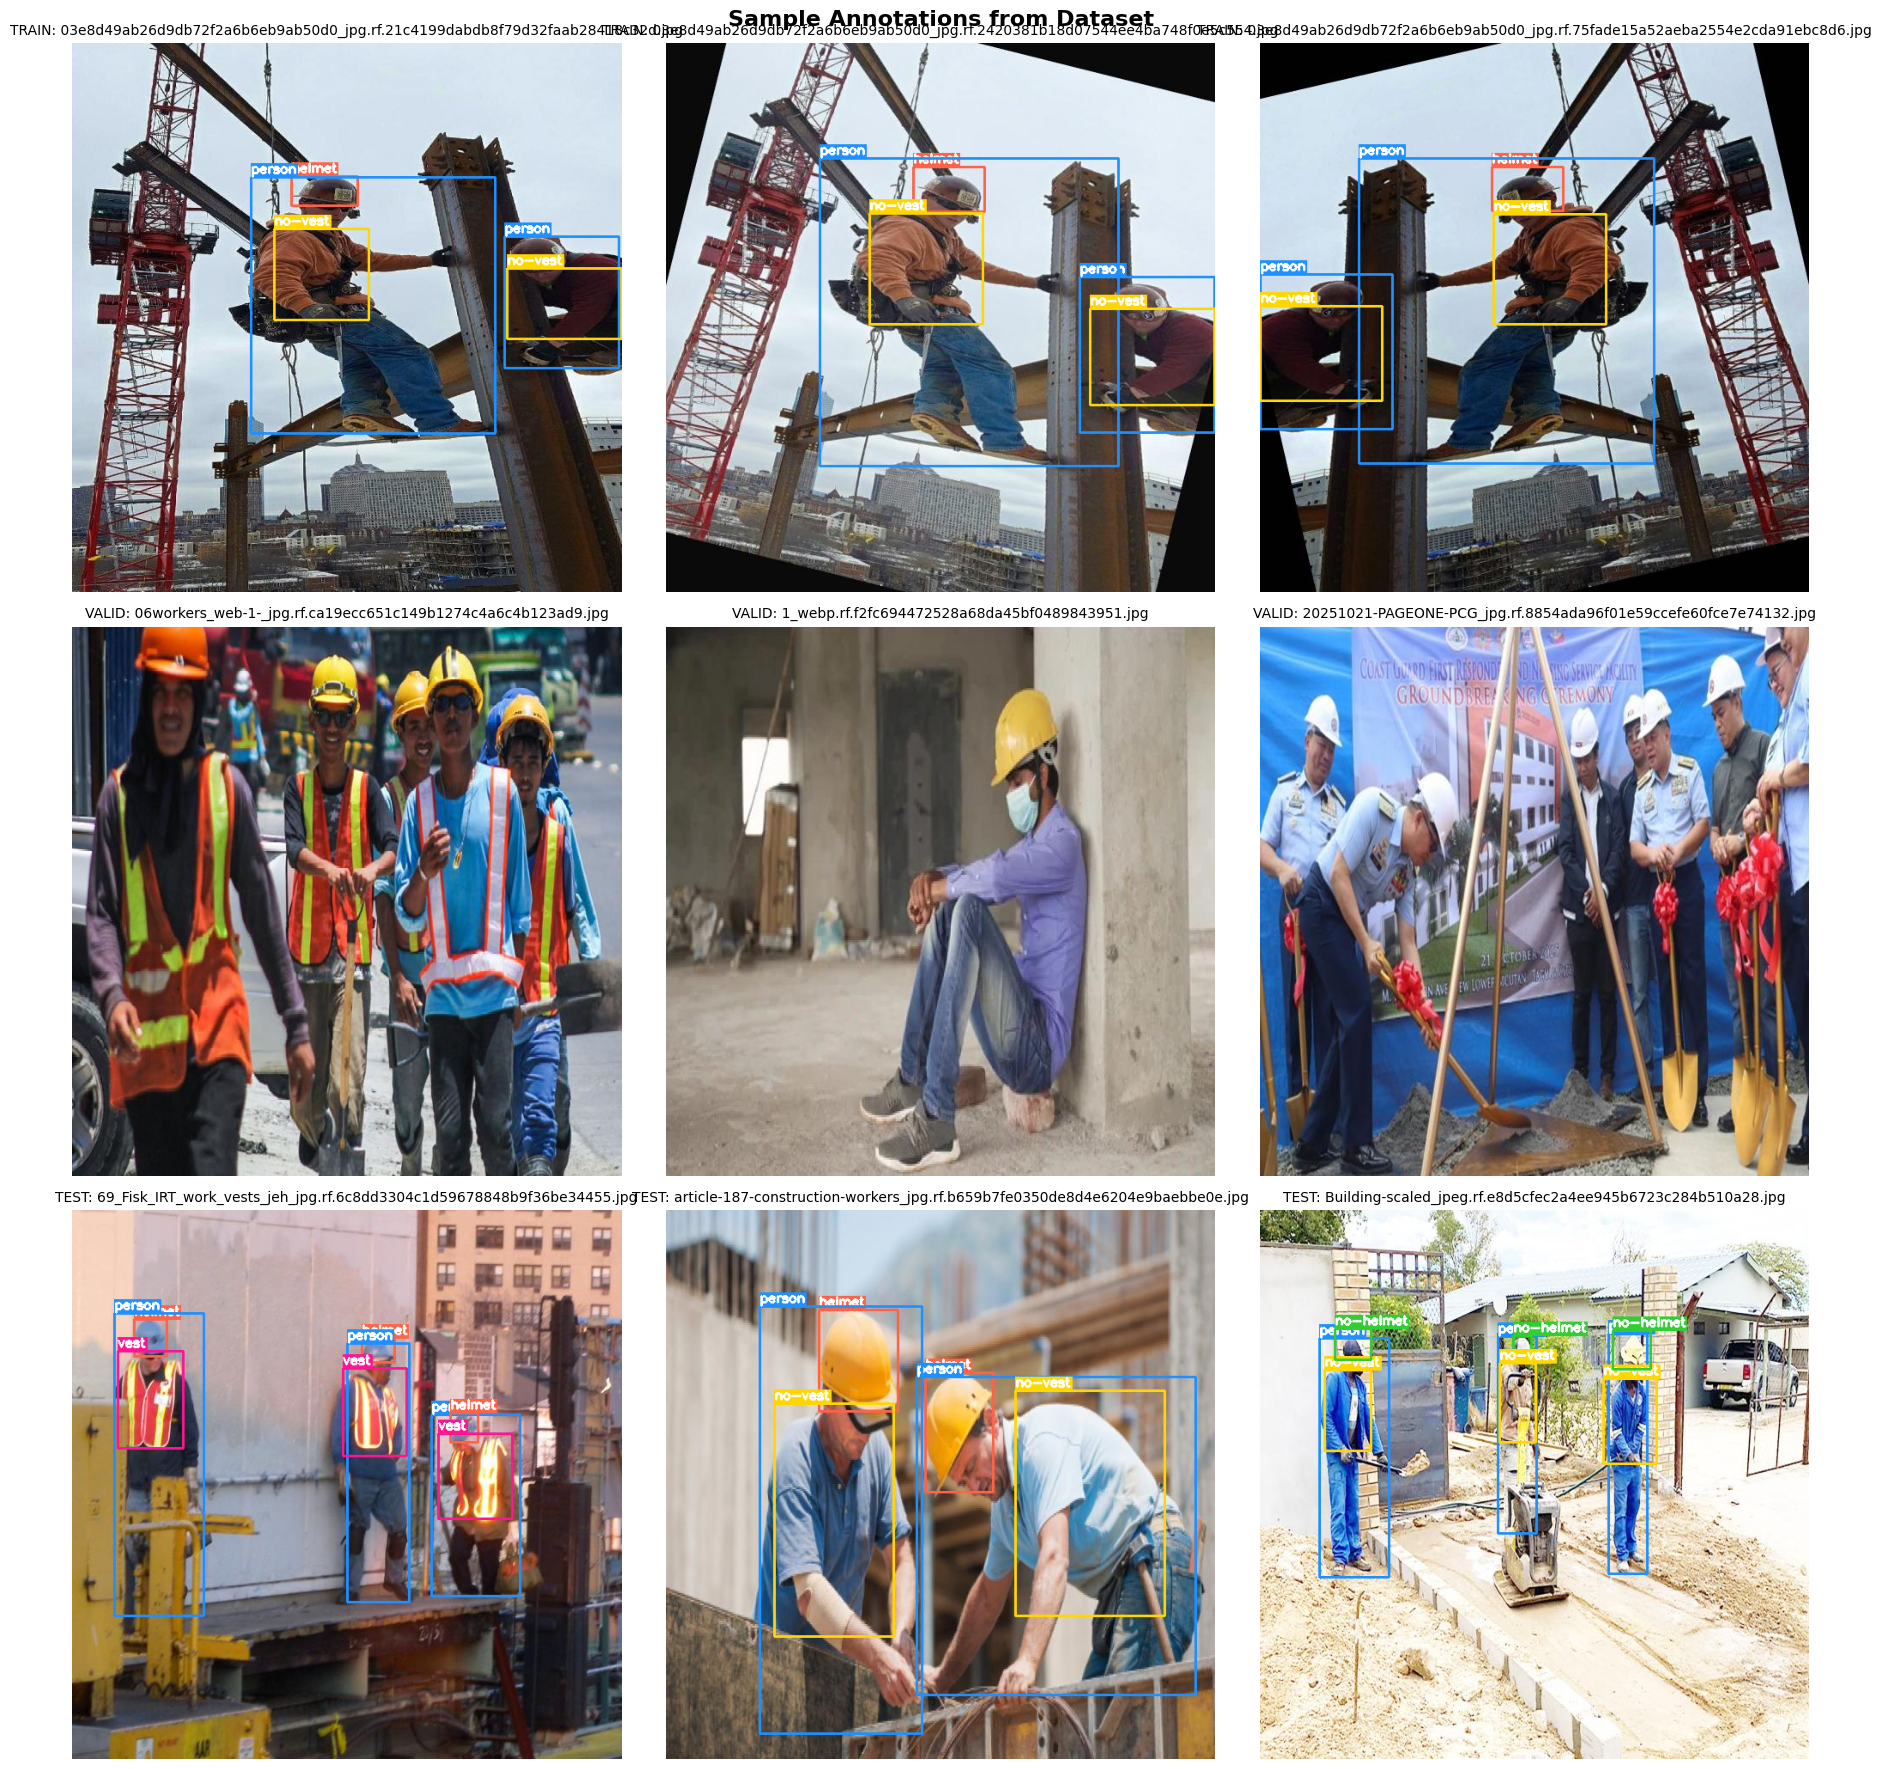


✅ Annotation visualization complete!


In [9]:
# ============================================================
# VISUALIZE SAMPLE ANNOTATIONS
# ============================================================
print("\n" + "="*60)
print("VISUALIZING SAMPLE ANNOTATIONS")
print("="*60)

def draw_yolo_boxes(image_path, label_path, class_names):
    """Draw bounding boxes on image from YOLO labels"""
    
    # Read image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Define colors for each class
    colors = {
        0: (255, 99, 71),    # helmet - tomato
        1: (50, 205, 50),    # no-helmet - lime green
        2: (255, 215, 0),    # no-vest - gold
        3: (30, 144, 255),   # person - dodger blue
        4: (255, 20, 147)    # vest - deep pink
    }
    
    # Read labels
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    
                    # Convert YOLO format to pixel coordinates
                    x_center_px = int(x_center * w)
                    y_center_px = int(y_center * h)
                    width_px = int(width * w)
                    height_px = int(height * h)
                    
                    # Calculate corners
                    x1 = int(x_center_px - width_px / 2)
                    y1 = int(y_center_px - height_px / 2)
                    x2 = int(x_center_px + width_px / 2)
                    y2 = int(y_center_px + height_px / 2)
                    
                    # Draw rectangle
                    color = colors.get(class_id, (255, 255, 255))
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Draw label
                    label = class_names.get(class_id, f"Class {class_id}")
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                    cv2.rectangle(img, (x1, y1 - label_size[1] - 4), 
                                (x1 + label_size[0], y1), color, -1)
                    cv2.putText(img, label, (x1, y1 - 5), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    return img

# Visualize samples from each split
print("\n📸 Creating annotation visualizations...")

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Sample Annotations from Dataset', fontsize=16, fontweight='bold')

for split_idx, split in enumerate(['train', 'valid', 'test']):
    images_dir = dataset_root / split / 'images'
    labels_dir = dataset_root / split / 'labels'
    
    if images_dir.exists():
        image_files = list(images_dir.glob('*'))[:3]  # Get first 3 images
        
        for img_idx, img_path in enumerate(image_files):
            label_path = labels_dir / f"{img_path.stem}.txt"
            
            # Draw boxes
            img_with_boxes = draw_yolo_boxes(img_path, label_path, class_names)
            
            # Display
            ax = axes[split_idx, img_idx]
            ax.imshow(img_with_boxes)
            ax.set_title(f'{split.upper()}: {img_path.name}', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.savefig('sample_annotations.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: sample_annotations.png")
plt.show()

print("\n✅ Annotation visualization complete!")

In [11]:
# ============================================================
# DATASET CREATION COMPLETE
# ============================================================
print("\n" + "="*60)
print("✅ DATASET CREATION COMPLETE!")
print("="*60)

print(f"""
══════════════════════════════════════════════════════════
DATASET SUMMARY - SAFETY EQUIPMENT DETECTOR v3
══════════════════════════════════════════════════════════
Project: Construction Site Safety Equipment Detection
Version: v3 (Production)
Date: October 27, 2025

DATASET STATISTICS:
──────────────────
Total Images: {total_imgs}
├─ Train: {train_imgs} images ({train_imgs/total_imgs*100:.1f}%)
├─ Valid: {valid_imgs} images ({valid_imgs/total_imgs*100:.1f}%)
└─ Test:  {test_imgs} images ({test_imgs/total_imgs*100:.1f}%)

Source Images: 104 (collected from Roboflow)
Augmentation Ratio: {total_imgs/104:.1f}x

Classes: {data_config['nc']}
""")

for class_id, class_name in class_names.items():
    if 'train' in results:
        count = results['train']['counts'].get(class_id, 0)
        total = results['train']['total']
        pct = (count/total*100) if total > 0 else 0
        print(f"├─ {class_name:<12}: {count:4d} annotations ({pct:5.1f}%)")

print(f"""
QUALITY CHECKS:
───────────────
✅ Folder structure verified
✅ Image-label pairing confirmed
✅ Class distribution analyzed
✅ Annotations visualized
✅ Ready for training!

FILES GENERATED:
────────────────
✅ class_distribution.png
✅ sample_annotations.png

NEXT STEPS:
───────────
→ Train model (v1: baseline)
→ Evaluate results
→ Iterate and improve (v2, v3)
→ Deploy production model!

══════════════════════════════════════════════════════════
""")

print("\n🚀 Ready to train my model!")
print("📓 Next: Open 02_model_training_complete.ipynb")


✅ DATASET CREATION COMPLETE!

══════════════════════════════════════════════════════════
DATASET SUMMARY - SAFETY EQUIPMENT DETECTOR v3
══════════════════════════════════════════════════════════
Project: Construction Site Safety Equipment Detection
Version: v3 (Production)
Date: October 27, 2025

DATASET STATISTICS:
──────────────────
Total Images: 236
├─ Train: 213 images (90.3%)
├─ Valid: 12 images (5.1%)
└─ Test:  11 images (4.7%)

Source Images: 104 (collected from Roboflow)
Augmentation Ratio: 2.3x

Classes: 5

├─ helmet      :  534 annotations ( 26.4%)
├─ no-helmet   :  150 annotations (  7.4%)
├─ no-vest     :  351 annotations ( 17.4%)
├─ person      :  672 annotations ( 33.2%)
├─ vest        :  315 annotations ( 15.6%)

QUALITY CHECKS:
───────────────
✅ Folder structure verified
✅ Image-label pairing confirmed
✅ Class distribution analyzed
✅ Annotations visualized
✅ Ready for training!

FILES GENERATED:
────────────────
✅ class_distribution.png
✅ sample_annotations.png

NEXT S